In [1]:
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
from rot_learner.dataset_trans import TransDataset
from rot_learner.util import retrieve_data
from rot_learner import main_mis
from rot_learner.dataset import RotDataset
import copy
from rot_learner.data_util import preprocess_config

import warnings
warnings.filterwarnings("ignore")

In [2]:
config_path = './snapshots/cifar10_resnet18/cifar10_resnet18_dp_baseline_epoch_299.pt'
PRED_ROTS = [0, 90, 180, 270]
PRED_TASK_NUM = len(PRED_ROTS)
device = 'cuda:0'
task_name = 'Rotation'

In [3]:
model, features_extractor, dloader,\
trainset_data, trainset_targets,\
valset_data, valset_targets,\
dataset, class_num = preprocess_config(config_path, None, device)

using model resnet18_dp
model weight loaded!
Files already downloaded and verified
Files already downloaded and verified


In [4]:
train_ds = RotDataset(trainset_data, PRED_ROTS, trainset_targets, dataset=dataset, train_mode=True)
val_ds = RotDataset(valset_data, PRED_ROTS, valset_targets, dataset=dataset, train_mode=False)
test_ds = RotDataset(dloader.all_test_data, PRED_ROTS, dloader.all_test_targets, dataset=dataset, train_mode=False)

trainloader = DataLoader(train_ds, batch_size=300, shuffle=True)
valloader = DataLoader(val_ds, batch_size=300, shuffle=False)
testloader = DataLoader(test_ds, batch_size=300, shuffle=False, pin_memory=False, num_workers=3)


In [5]:
rot_net = main_mis.train(features_extractor, PRED_TASK_NUM, 512, 3, trainloader, device, dataset)
cls_res, rot_res = main_mis.test(rot_net, model, testloader, class_num, PRED_TASK_NUM, device)

100%|██████████| 34/34 [00:07<00:00,  4.75it/s, acc=92.98%, aug_acc=52.83%]


In [6]:
pred_scores, pred_corrects, gt_labels, pred_labels, pred_scores_all, pred_scores_for_gts, pred_features, pred_logits, pred_loss_all = cls_res
rot_scores, rot_accs, rot_scores_full, rot_scores_all, rot_features, rot_logits, all_rot_corrects, rot_loss_all = rot_res

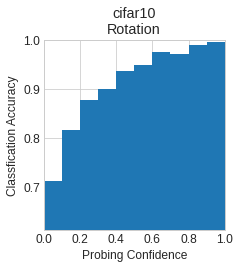

In [7]:
import rot_learner
from importlib import reload
reload(rot_learner.util)
from rot_learner.util import show_ssl_cls, show_dist


show_ssl_cls(np.array(pred_scores), pred_scores_for_gts, np.array(pred_corrects), np.array(rot_scores_full)[:, 0], rot_accs, gt_labels, 0, None, f'Rotation', 
            config={'title': f'{dataset}\n{task_name}','xlabel':'Probing Confidence', 'alpha':1}
        )

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


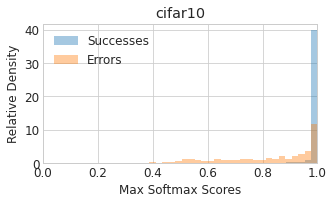

In [8]:
draw_config = {'kde': False, 'norm_hist': True, 'bins':30}

show_dist(pred_scores, pred_corrects, None, 'Max Softmax Scores', draw_config, {'title': f'{dataset}', 'xlabel': 'Max Softmax Scores'})

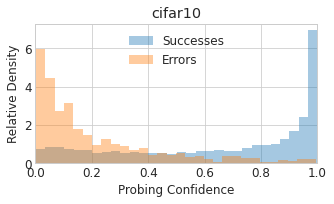

In [9]:
show_dist(np.array(rot_scores_full)[:, 0], pred_corrects, None, 'Probing Confidence', draw_config, {'title': f'{dataset}', 'xlabel': 'Probing Confidence'})